In [30]:
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import pandas as pd

# Tratamento dos dados

In [2]:
wine_quality = fetch_ucirepo(id=186)

In [3]:
X = wine_quality.data.features
y = wine_quality.data.targets

X_white = X[1599:]
y_white = y[1599:]

X_train, X_test, y_train, y_test = train_test_split(X_white, y_white, test_size=0.2, random_state=42)

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

scoring = {'f1_weighted': 'f1_weighted', 'accuracy': make_scorer(accuracy_score)}

Text(0, 0.5, 'Frequência')

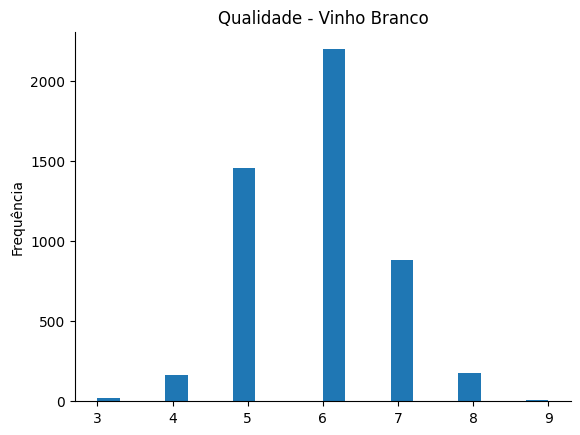

In [39]:
y_white['quality'].plot(kind='hist', bins=20, title='Qualidade - Vinho Branco')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.ylabel('Frequência')

# Árvore de Decisão

In [5]:
dt_param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2', None]
    }

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    cv=5,
    scoring=scoring,
    refit='f1_weighted',
    verbose=1,
    n_jobs=-1,
)

dt = grid_search_dt.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [9]:
print("\nTop 5 combinações de parâmetros e seus scores:")
dt_results = dt.cv_results_
dt_top_5_indices_f1 = dt_results['rank_test_f1_weighted'].argsort()[:5]

for rank, idx in enumerate(dt_top_5_indices_f1, start=1):
    dt_params = dt_results['params'][idx]
    dt_f1 = dt_results['mean_test_f1_weighted'][idx]
    dt_accuracy = dt_results['mean_test_accuracy'][idx]
    print(f"Rank {rank}:")
    print(f"  Parâmetros: {dt_params}")
    print(f"  Score médio (F1): {dt_f1:.4f}")
    print(f"  Acurácia média: {dt_accuracy:.4f}\n")


Top 5 combinações de parâmetros e seus scores:
Rank 1:
  Parâmetros: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Score médio (F1): 0.5831
  Acurácia média: 0.5819

Rank 2:
  Parâmetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
  Score médio (F1): 0.5793
  Acurácia média: 0.5809

Rank 3:
  Parâmetros: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
  Score médio (F1): 0.5793
  Acurácia média: 0.5809

Rank 4:
  Parâmetros: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
  Score médio (F1): 0.5774
  Acurácia média: 0.5773

Rank 5:
  Parâmetros: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}
  Score médio (F1): 0.5774
  Acurácia média: 0.5773



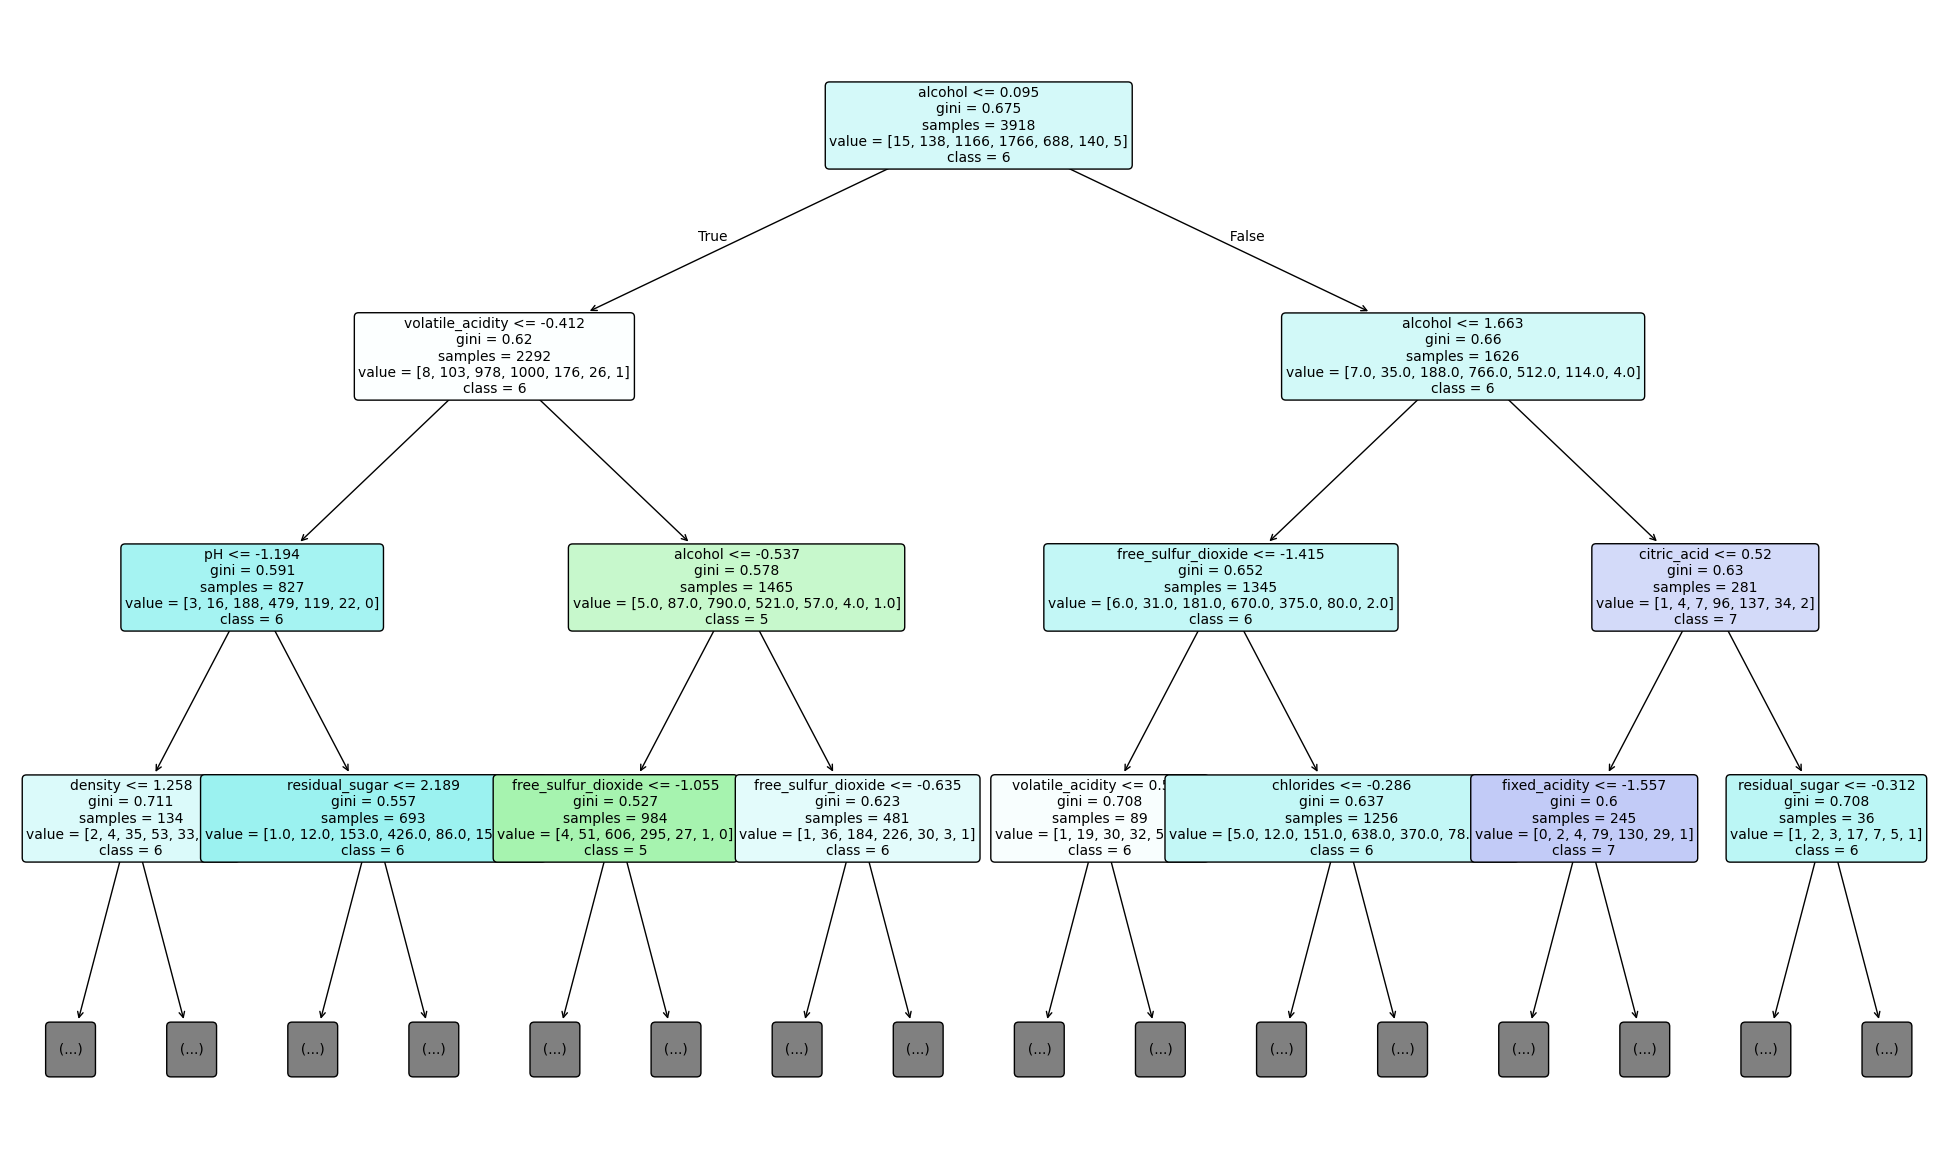

In [10]:
plt.figure(figsize=(25,15))

plot_tree(dt.best_estimator_,
          feature_names=X_train.columns,
          class_names=[str(i) for i in dt.best_estimator_.classes_],
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=10)

plt.show()

In [20]:
y_pred_dt = dt.best_estimator_.predict(X_test_scaled)
dt_cm = confusion_matrix(y_test, y_pred_dt)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average='weighted', zero_division=1)

best_params_dt = dt.best_estimator_.get_params()

print(f"\nParâmetros usados:")
print("\n".join([f"{key}: {value}" for key, value in best_params_dt.items() if key in dt_param_grid]))


print(f"\nMatriz de Confusão:\n\n {dt_cm}")
print(f"\nAcurácia: {dt_accuracy}")
print(f"F1: {dt_f1}\n")

print(classification_report(y_test, y_pred_dt, zero_division=1))


Parâmetros usados:
criterion: gini
max_depth: None
max_features: None
min_samples_leaf: 1
min_samples_split: 2

Matriz de Confusão:

 [[  0   1   2   2   0   0   0]
 [  1   7   7   7   2   1   0]
 [  0   8 186  82  10   5   0]
 [  1  11  79 276  50  14   1]
 [  0   2   5  56 112  17   0]
 [  0   0   0   9   9  17   0]
 [  0   0   0   0   0   0   0]]

Acurácia: 0.610204081632653
F1: 0.6127102627265507

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.24      0.28      0.26        25
           5       0.67      0.64      0.65       291
           6       0.64      0.64      0.64       432
           7       0.61      0.58      0.60       192
           8       0.31      0.49      0.38        35
           9       0.00      1.00      0.00         0

    accuracy                           0.61       980
   macro avg       0.35      0.52      0.36       980
weighted avg       0.62      0.61      0.61       98

# Random Forest

In [13]:
rf_param_grid = {
    'criterion': ['gini'],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=5,
    scoring=scoring,
    refit='f1_weighted',
    verbose=1,
    n_jobs=-1,
)

rf = grid_search_rf.fit(X_train_scaled, y_train.values.ravel())

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


In [21]:
print("\nTop 5 combinações de parâmetros e seus scores:")
rf_results = rf.cv_results_
rf_top_5_indices_f1 = rf_results['rank_test_f1_weighted'].argsort()[:5]

for rank, idx in enumerate(rf_top_5_indices_f1, start=1):
    rf_params = rf_results['params'][idx]
    rf_f1 = rf_results['mean_test_f1_weighted'][idx]
    rf_accuracy = rf_results['mean_test_accuracy'][idx]
    print(f"Rank {rank}:")
    print(f"  Parâmetros: {rf_params}")
    print(f"  Score médio (F1): {rf_f1:.4f}")
    print(f"  Acurácia média: {rf_accuracy:.4f}\n")


Top 5 combinações de parâmetros e seus scores:
Rank 1:
  Parâmetros: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
  Score médio (F1): 0.6491
  Acurácia média: 0.6626

Rank 2:
  Parâmetros: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
  Score médio (F1): 0.6491
  Acurácia média: 0.6626

Rank 3:
  Parâmetros: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Score médio (F1): 0.6478
  Acurácia média: 0.6605

Rank 4:
  Parâmetros: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Score médio (F1): 0.6478
  Acurácia média: 0.6605

Rank 5:
  Parâmetros: {'bootstrap': False, '

In [23]:
y_pred_rf = rf.best_estimator_.predict(X_test_scaled)
rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=1)

rf_best_params = rf.best_estimator_.get_params()

print(f"\nParâmetros usados:")
print("\n".join([f"{key}: {value}" for key, value in rf_best_params.items() if key in rf_param_grid]))


print(f"\nMatriz de Confusão:\n\n {rf_cm}")
print(f"\nAcurácia: {rf_accuracy}")
print(f"F1: {rf_f1}\n")

print(classification_report(y_test, y_pred_rf, zero_division=1))


Parâmetros usados:
bootstrap: True
criterion: gini
max_depth: None
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 300

Matriz de Confusão:

 [[  0   0   2   3   0   0]
 [  0   6  11   8   0   0]
 [  0   4 202  83   2   0]
 [  0   0  61 349  22   0]
 [  0   0   5  71 113   3]
 [  0   0   1   8  10  16]]

Acurácia: 0.7
F1: 0.6476946909273225

              precision    recall  f1-score   support

           3       1.00      0.00      0.00         5
           4       0.60      0.24      0.34        25
           5       0.72      0.69      0.71       291
           6       0.67      0.81      0.73       432
           7       0.77      0.59      0.67       192
           8       0.84      0.46      0.59        35

    accuracy                           0.70       980
   macro avg       0.77      0.46      0.51       980
weighted avg       0.71      0.70      0.69       980



# MLP

In [35]:
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [15000]
}

random_search_mlp = RandomizedSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_distributions=mlp_param_grid,
    cv=5,
    scoring=scoring,
    refit='f1_weighted',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

mlp = random_search_mlp.fit(X_train_scaled, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [37]:
print("\nTop 5 combinações de parâmetros e seus scores:")
mlp_results = mlp.cv_results_
mlp_top_5_indices_f1 = mlp_results['rank_test_f1_weighted'].argsort()[:5]

for rank, idx in enumerate(mlp_top_5_indices_f1, start=1):
    mlp_params = mlp_results['params'][idx]
    mlp_f1 = mlp_results['mean_test_f1_weighted'][idx]
    mlp_accuracy = mlp_results['mean_test_accuracy'][idx]
    print(f"Rank {rank}:")
    print(f"  Parâmetros: {mlp_params}")
    print(f"  Score médio (F1): {mlp_f1:.4f}")
    print(f"  Acurácia média: {mlp_accuracy:.4f}\n")


Top 5 combinações de parâmetros e seus scores:
Rank 1:
  Parâmetros: {'solver': 'adam', 'max_iter': 15000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.01, 'activation': 'tanh'}
  Score médio (F1): 0.6081
  Acurácia média: 0.6113

Rank 2:
  Parâmetros: {'solver': 'lbfgs', 'max_iter': 15000, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}
  Score médio (F1): 0.5953
  Acurácia média: 0.5960

Rank 3:
  Parâmetros: {'solver': 'lbfgs', 'max_iter': 15000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}
  Score médio (F1): 0.5953
  Acurácia média: 0.5960

Rank 4:
  Parâmetros: {'solver': 'lbfgs', 'max_iter': 15000, 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'tanh'}
  Score médio (F1): 0.5851
  Acurácia média: 0.5875

Rank 5:
  Parâmetros: {'solver': 'adam', 'max_iter': 15000, 'learning_rate': 'adaptive', 'hidden_la

In [38]:
y_pred_mlp = mlp.best_estimator_.predict(X_test_scaled)
mlp_cm = confusion_matrix(y_test, y_pred_mlp)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
mlp_f1 = f1_score(y_test, y_pred_mlp, average='weighted', zero_division=1)

mlp_best_params = mlp.best_estimator_.get_params()

print(f"\nParâmetros usados:")
print("\n".join([f"{key}: {value}" for key, value in mlp_best_params.items() if key in mlp_param_grid]))


print(f"\nMatriz de Confusão:\n\n {mlp_cm}")
print(f"\nAcurácia: {mlp_accuracy}")
print(f"F1: {mlp_f1}\n")

print(classification_report(y_test, y_pred_mlp, zero_division=1))


Parâmetros usados:
activation: tanh
alpha: 0.01
hidden_layer_sizes: (100, 50)
learning_rate: adaptive
max_iter: 15000
solver: adam

Matriz de Confusão:

 [[  1   0   3   1   0   0]
 [  1  12   6   4   2   0]
 [  0  16 189  73  13   0]
 [  0   8  71 294  55   4]
 [  1   1   8  60 111  11]
 [  0   0   0   8   8  19]]

Acurácia: 0.6387755102040816
F1: 0.6398346943056267

              precision    recall  f1-score   support

           3       0.33      0.20      0.25         5
           4       0.32      0.48      0.39        25
           5       0.68      0.65      0.67       291
           6       0.67      0.68      0.67       432
           7       0.59      0.58      0.58       192
           8       0.56      0.54      0.55        35

    accuracy                           0.64       980
   macro avg       0.53      0.52      0.52       980
weighted avg       0.64      0.64      0.64       980

